In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pickle
import time
from ipypb import track

import WRCP_ALS3 as wrcp
from general_functions import sqrt_err_relative, check_coo_tensor, gen_coo_tensor

### Zero launch of a function(for NUMBA):

In [2]:
init_shape = (100, 100, 100)
coo, vals = gen_coo_tensor(init_shape, density=0.002)
assert check_coo_tensor(coo)!= "Bad"

In [4]:
%%time

max_iter = 12
rank = 5
seed = 13

a, b, c, _, _ = wrcp.wrcp_als3(
    coo, vals, init_shape,
    rank=rank,
    l2=0.25,
    max_iter=max_iter,
    seed=seed,
    show_iter=False,
    it_over=False,
)
rerr = sqrt_err_relative(
    coo, vals, init_shape, a, b, c,
)
print(rerr)

0.3425008883587162
CPU times: user 55.1 ms, sys: 0 ns, total: 55.1 ms
Wall time: 54.9 ms


### Load the data:

In [5]:
path_data = "Link_Prediction_Data/FB15K/"
entity_list = pickle.load(open(path_data + 'entity_list', 'rb'))
relation_list = pickle.load(open(path_data + 'relation_list', 'rb'))

train_triples = pickle.load(open(path_data + 'train_triples', 'rb'))
valid_triples = pickle.load(open(path_data + 'valid_triples', 'rb'))
test_triples = pickle.load(open(path_data + 'test_triples', 'rb'))

entity_map = pickle.load(open(path_data + 'entity_map', 'rb'))
relation_map = pickle.load(open(path_data + 'relation_map', 'rb'))

In [9]:
print(entity_list[:3], "\n", len(entity_list))

['Northridge', 'Croatian American', 'Bob Clampett'] 
 14240


In [10]:
print(relation_list[:3], "\n", len(relation_list))

['/people/person/children', '/location/statistical_region/rent50_1./measurement_unit/dated_money_value/currency', '/base/locations/countries/continent'] 
 1172


In [11]:
len(train_triples)

459209

In [12]:
len(valid_triples)

47788

In [13]:
len(test_triples)

56361

In [14]:
list(entity_map.items())[:2]

[('Northridge', 0), ('Croatian American', 1)]

In [15]:
list(relation_map.items())[:2]

[('/people/person/children', 0),
 ('/location/statistical_region/rent50_1./measurement_unit/dated_money_value/currency',
  1)]

### (OPTIONAL)If we want to merge train and valid sets:

In [12]:
train_triples.extend(valid_triples)

In [13]:
len(train_triples)

506997

### Create Sparse COO Train Tensor:

In [6]:
values = [1] * len(train_triples)
values = np.array(values, dtype=np.float64)

coords = np.array(train_triples, dtype=np.int32)
nnz = len(train_triples)
data_shape = (len(entity_list), len(relation_list), len(entity_list))
data_shape

(14240, 1172, 14240)

## WRCP-ALS3:

In [7]:
max_iter = 2
rank = 10
l2 = 3e0
seed = 13

In [8]:
%%time
a, b, c, err_arr, it = wrcp.wrcp_als3(
    coords, values, data_shape,
    rank=rank,
    l2=l2,
    max_iter=max_iter,
    seed=seed,
    show_iter=False,
    it_over=False,
)

CPU times: user 1min 32s, sys: 441 ms, total: 1min 32s
Wall time: 1min 32s


In [9]:
rerr = sqrt_err_relative(
    coords, values, data_shape, a, b, c,
)
print(f"Relative error = {rerr}")

Relative error = 0.4905787024539982


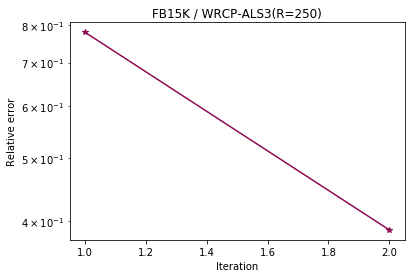

In [33]:
plt.xlabel("Iteration")
plt.ylabel("Relative error")
plt.title(f"FB15K / WRCP-ALS3(R={rank})")
#plt.xticks(np.arange(it))
plt.yscale("log")
plt.plot(np.arange(1, it+1), err_arr[:it], '-*', c="#8b0a50")

In [11]:
from numba import jit
from numba.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings

warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)


@jit(nopython=True)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

@jit(nopython=True)
def hit_rate(train_triples, test_triples, a, b, c,
             how_many=10, iter_show=False, freq=3000):
    
    total = len(test_triples)
    hit = 0
    iteration = 0
    for entity in test_triples:
        iteration += 1
        p = entity[0]
        q = entity[1]
        r = entity[2]

        candidate_values = np.sum(a[p, :] * b[q, :] * c, axis=1)
        candidate_values = sigmoid(candidate_values)
        
        top = np.argsort(candidate_values)[::-1]
        ltop = [i for i in top]
        

        for tr in train_triples:
                
            if (p == tr[0]) and (q == tr[1]):
                if tr[2] == r:
                    print(tr, entity)
                if tr[2] in ltop:
                    ltop.remove(tr[2])
        
        ltop = ltop[:how_many]
        
        for x in ltop:
            if x == r:
                hit += 1
        if iter_show:
            if iteration % freq == 0:
                print(hit / iteration, hit, iteration)
            
    return hit / total, hit, total

hit_rate(
    train_triples[:5],
    test_triples[:5],
    a, b, c, 10,
    iter_show=False,
    freq=3000,
)

(0.2, 1, 5)

In [12]:
%%time
hit_rate(train_triples, test_triples, a, b, c, 10, iter_show=False, freq=3000)

CPU times: user 4min 25s, sys: 573 ms, total: 4min 26s
Wall time: 4min 25s


(0.12602686254679654, 7103, 56361)

In [13]:
%%time
hit_rate(train_triples, valid_triples, a, b, c, 10, iter_show=False, freq=3000)

CPU times: user 3min 44s, sys: 560 ms, total: 3min 45s
Wall time: 3min 44s


(0.12639156273541474, 6040, 47788)

### Save Factors:

In [ ]:
path_factors = "Link_Prediction_Factors/FB15K/"

pickle.dump(a, open(path_factors + 'A_factor', 'wb'))
pickle.dump(b, open(path_factors + 'B_factor', 'wb'))
pickle.dump(c, open(path_factors + 'C_factor', 'wb'))
pickle.dump(err_arr, open(path_factors + 'Errors', 'wb'))

## Find best parameters:

In [14]:
ranks = (25, 50, 100, 200, 250)
l2 = 3e0
n_iter = 2
seed = 13

In [15]:
table_results = pd.DataFrame(
    np.zeros((len(ranks), 8)),
    index=[i for i in range(1, 6)],
    columns=("iter", "rank", "l2", "time_train", "time_hr", "error", "hr_valid", "hr_test"),
)
table_results

,iter,rank,l2,time_train,time_hr,error,hr_valid,hr_test
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
idx = 0
for rank in track(ranks):
    idx += 1
    # Train model
    start_tr = time.time()
    a, b, c, err_arr, it = wrcp.wrcp_als3(
        coords, values, data_shape,
        rank=rank,
        l2=l2,
        max_iter=n_iter,
        seed=seed,
        show_iter=False,
        it_over=False,
    )
    end_tr = time.time()
            
    # Find relative error
    rerr = sqrt_err_relative(
        coords, values, data_shape, a, b, c,
    )
     
        
    # Find Hit Rate on a validation set
    start_hr = time.time()
    hr_valid, _, _ = hit_rate(train_triples, valid_triples, a, b, c, 10)
    # Find Hit Rate on a test set
    hr_test, _, _ = hit_rate(train_triples, test_triples, a, b, c, 10)
    end_hr = time.time()
            
    table_results.loc[idx]["iter"] = n_iter
    table_results.loc[idx]["rank"] = rank
    table_results.loc[idx]["l2"] = l2
    table_results.loc[idx]["time_train"] = end_tr - start_tr
    table_results.loc[idx]["time_hr"] = end_hr - start_hr
    table_results.loc[idx]["error"] = rerr
    table_results.loc[idx]["hr_valid"] = hr_valid
    table_results.loc[idx]["hr_test"] = hr_test

 [████████████████████████████████████████████████████████████] 5/5 [03:10:36<01:20:40, 2287.25s/it]

In [17]:
table_results

,iter,rank,l2,time_train,time_hr,error,hr_valid,hr_test
1,2.0,25.0,3.0,96.812222,607.982382,0.429689,0.163598,0.161246
2,2.0,50.0,3.0,131.789263,800.068590,0.406800,0.214803,0.212186
3,2.0,100.0,3.0,285.574123,1205.464221,0.389291,0.275697,0.273576
4,2.0,200.0,3.0,985.066544,2482.327854,0.390810,0.323303,0.315253
5,2.0,250.0,3.0,1574.199990,3265.579626,0.387988,0.325165,0.324267


In [18]:
table_results.to_csv("Link_Prediction_Factors/FB15K/results.csv")

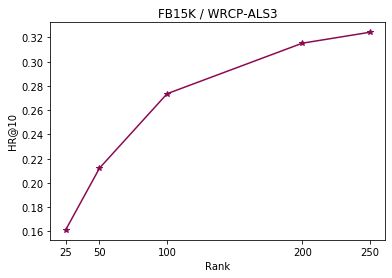

In [32]:
plt.xlabel("Rank")
plt.ylabel("HR@10")
plt.title(f"FB15K / WRCP-ALS3")
plt.xticks(table_results['rank'])
#plt.yscale("log")
plt.plot(table_results['rank'], table_results['hr_test'], '-*', c="#8b0a50")

## We can load calculated factors:

In [3]:
path_factors = "Link_Prediction_Factors/FB15K/"

a = pickle.load(open(path_factors + 'A_factor', 'rb'))
b = pickle.load(open(path_factors + 'B_factor', 'rb'))
c = pickle.load(open(path_factors + 'C_factor', 'rb'))

In [21]:
hit_rate(train_triples, test_triples, a, b, c, 10)

0.341 682 2000
0.32975 1319 4000
0.3285 1971 6000
0.32625 2610 8000
0.3287 3287 10000
0.3329166666666667 3995 12000
0.33314285714285713 4664 14000
0.3335 5336 16000
0.3333333333333333 6000 18000
0.33095 6619 20000
0.3321363636363636 7307 22000
0.331625 7959 24000
0.3323076923076923 8640 26000
0.33182142857142854 9291 28000
0.3323333333333333 9970 30000
0.33225 10632 32000
0.33276470588235296 11314 34000
0.33361111111111114 12010 36000
0.3335526315789474 12675 38000
0.3337 13348 40000
0.33330952380952383 13999 42000
0.3335681818181818 14677 44000
0.33360869565217394 15346 46000
0.33420833333333333 16042 48000
0.33436 16718 50000
0.3340192307692308 17369 52000
0.3337037037037037 18020 54000
0.33325 18662 56000


(0.3332446195063963, 18782, 56361)

In [ ]:
hit_rate(train_triples, valid_triples, a, b, c, 10)

## Let's look at Tucker TD:

In [4]:
import polara.lib.hosvd as hosvd

In [10]:
%%time
core_shape = (50, 50, 50)
p, q, r, g = hosvd.tucker_als(
    idx=coords,
    val=values,
    shape=data_shape,
    core_shape=core_shape,
    iters=100,
    growth_tol=0.01,
    batch_run=False,
    seed=None,
)

Step 1 of 100
growth of the core: 1.000000
Step 2 of 100
growth of the core: 0.111823
Step 3 of 100
growth of the core: 0.008425
Core is no longer growing. Norm of the core: 298.005022
Done
CPU times: user 1min 5s, sys: 1.46 s, total: 1min 7s
Wall time: 39.1 s


### Write function to calculate the error:

In [6]:
from numba import jit

In [7]:
@jit(nopython=True) 
def sqrt_err_tucker(coo_tensor, vals, shape, a, b, c, g):
    result = 0.0
    for item in range(coo_tensor.shape[0]):
        coord = coo_tensor[item]
        elem = 0.0
        for p in range(a.shape[1]):
            for q in range(b.shape[1]):
                for r in range(c.shape[1]):
                    elem += g[p, q, r] * a[coord[0], p] * b[coord[1], q] * c[coord[2], r]
        
        result += (vals[item] - elem)**2  
    return np.sqrt(result)

In [8]:
@jit(nopython=True) 
def sqrt_err_relative_tucker(coo_tensor, vals, shape, a, b, c, g):
    result = sqrt_err_tucker(coo_tensor, vals, shape, a, b, c, g)        
    return result / np.sqrt((vals**2).sum())

In [11]:
rerr = sqrt_err_relative_tucker(
    coords,
    values,
    data_shape,
    p,
    q,
    r,
    g,
)
print(f"Relative error = {rerr}")

Relative error = 0.8692521793191307
